In [1]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.utils import util

In [2]:
pickled_lens_list = os.path.join(config.machine.dir_01, '01_hlwas_sim_detectable_lens_list.pkl')
lens_list = util.unpickle(pickled_lens_list)

# Detectable and candidate lens counts

Number of detectable strong lenses per square degree of simulated area, candidate strong lenses

In [3]:
# combine CSVs from each run into one CSV
data_dir = config.machine.dir_00
total_csv = os.path.join(data_dir, 'total_pop.csv')
detectable_csv = os.path.join(data_dir, 'detectable_pop.csv')
util.delete_if_exists(total_csv)
util.delete_if_exists(detectable_csv)
total_df = util.combine_all_csvs(data_dir, 'total', total_csv)
detectable_df = util.combine_all_csvs(data_dir, 'detectable', detectable_csv)

Wrote combined CSV to /data/bwedig/mejiro/pipeline/00/total_pop.csv
Wrote combined CSV to /data/bwedig/mejiro/pipeline/00/detectable_pop.csv


In [4]:
import mejiro
module_path = os.path.dirname(mejiro.__file__)
skypy_config = os.path.join(module_path, 'data', 'roman_hlwas.yml')
config_dict = util.load_skypy_config(skypy_config)
survey_area = float(config_dict['fsky'][:-5])

runs = len(glob(os.path.join(data_dir, "total_pop_*.csv")))

total_area = survey_area * runs
print(f'{runs} runs of {survey_area} sq. deg. each gives {total_area} sq. deg. total')

50 runs of 5.0 sq. deg. each gives 250.0 sq. deg. total


In [5]:
print(f'{len(total_df)} candidate strong lenses')
print(f'{len(detectable_df)} detectable strong lenses')

fraction_detectable = len(detectable_df) / len(total_df)
print(f'Fraction of candidate strong lenses that are detectable: {fraction_detectable:.5f}')

1591139 candidate strong lenses
452 detectable strong lenses
Fraction of candidate strong lenses that are detectable: 0.00028


In [6]:
total_per_sq_deg = len(total_df) / total_area
print(f'Candidate strong lenses per sq. deg.: {round(total_per_sq_deg)}')
det_per_sq_deg = len(detectable_df) / total_area
print(f'Detectable strong lenses per sq. deg.: {det_per_sq_deg:.2f}')

Candidate strong lenses per sq. deg.: 6365
Detectable strong lenses per sq. deg.: 1.81


In [7]:
det_per_exposure = det_per_sq_deg * 0.281
print(f'Detectable strong lenses per exposure: {det_per_exposure:.2f}')

Detectable strong lenses per exposure: 0.51


# How much work are the various filters doing?

`filter_1` is Einstein radius and half-light radius, and `filter_2` is SNR > 10. The other detectability criteria are combined into the difference between candidate and detectable.

In [8]:
filters = util.unpickle_all(config.machine.dir_00, 'filtered_sample_')

num_filter_1 = np.sum([d['num_filter_1'] for d in filters])
num_filter_2 = np.sum([d['num_filter_2'] for d in filters])

percent_filter_1 = num_filter_1 / len(total_df) * 100
percent_filter_2 = num_filter_2 / len(total_df) * 100

print(f'{num_filter_1} ({percent_filter_1:.2f}%) candidate strong lenses caught in filter 1')
print(f'{num_filter_2} ({percent_filter_2:.2f}%) candidate strong lenses caught in filter 2')

1869 (0.12%) candidate strong lenses caught in filter 1
1587843 (99.79%) candidate strong lenses caught in filter 2


# Subhalo statistics

In [9]:
stats_list = util.unpickle_all(os.path.join(config.machine.dir_02, 'stats'), 'subhalo_stats_')

In [10]:
original_einstein_radii = [d['original_einstein_radius'] for d in stats_list]
adjusted_einstein_radii = [d['adjusted_einstein_radius'] for d in stats_list]
percent_change_einstein_radii = [d['percent_change_einstein_radius'] for d in stats_list]
effective_lensing_masses = [d['effective_lensing_mass'] for d in stats_list]
adjusted_lensing_masses = [d['adjusted_lensing_mass'] for d in stats_list]
percent_change_lensing_masses = [d['percent_change_lensing_mass'] for d in stats_list]
total_masses_subhalos_within_einstein_radius = [d['total_mass_subhalos_within_einstein_radius'] for d in stats_list]
total_subhalo_masses = [d['total_subhalo_mass'] for d in stats_list]
percent_subhalo_masses_within_einstein_radius = [d['percent_subhalo_mass_within_einstein_radius'] for d in stats_list]

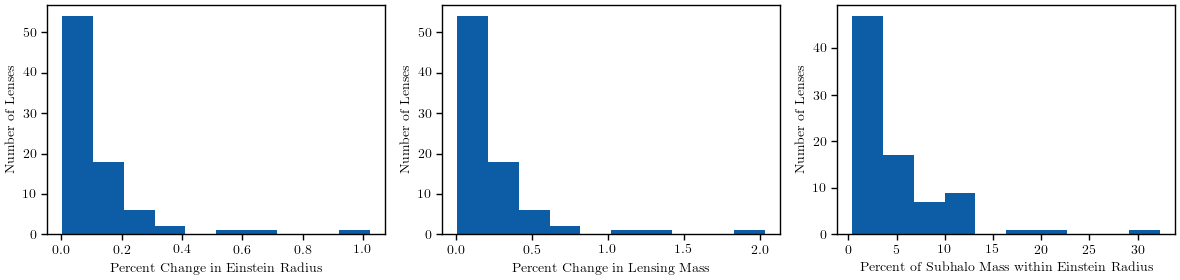

In [11]:
f, ax = plt.subplots(1, 3, figsize=(12, 3))
ax[0].hist(percent_change_einstein_radii)
ax[0].set_xlabel('Percent Change in Einstein Radius')
ax[0].set_ylabel('Number of Lenses')
ax[1].hist(percent_change_lensing_masses)
ax[1].set_xlabel('Percent Change in Lensing Mass')
ax[1].set_ylabel('Number of Lenses')
ax[2].hist(percent_subhalo_masses_within_einstein_radius)
ax[2].set_xlabel('Percent of Subhalo Mass within Einstein Radius')
ax[2].set_ylabel('Number of Lenses')
plt.tight_layout()
plt.show()

In [12]:
mean = np.mean(percent_change_einstein_radii)
stdev = np.std(percent_change_einstein_radii)

print(f'Mean percent change in Einstein radius: {mean:.2f}')
print(f'Standard deviation of percent change in Einstein radius: {stdev:.2f}')

Mean percent change in Einstein radius: 0.12
Standard deviation of percent change in Einstein radius: 0.15
